# 0. Imports

In [264]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import random as rand
import gym
import time

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

#!pip install progressbar
import progressbar as pb

# 1. Environment & setup

In [2]:
env = gym.make('PongDeterministic-v4')
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print("List of available actions: ", env.unwrapped.get_action_meanings())
print('Device is {}.'.format(device))
NOOP = 0
RIGHT = 4
LEFT = 5

List of available actions:  ['NOOP', 'FIRE', 'RIGHT', 'LEFT', 'RIGHTFIRE', 'LEFTFIRE']
Device is cuda:0.


# 2. Preprocessing

In [29]:
def preprocess(frames, bg=(144,109)):
    i = np.asarray(frames)

    crop = [frame[35:195,:,:] for frame in i]
    downsample = np.asarray([frame[::2,::2,0] for frame in crop])
    for frame in downsample:
        frame[frame==bg[0]] = 0
        frame[frame==bg[1]] = 0
        frame[frame!=0] = 1
    
    #downsample = np.swapaxes(downsample,0,1)
    
    return torch.from_numpy(downsample).float().to(device).unsqueeze(0)

Test preprocessing function.

Output of preprocess function is shaped torch.Size([1, 2, 80, 80]).


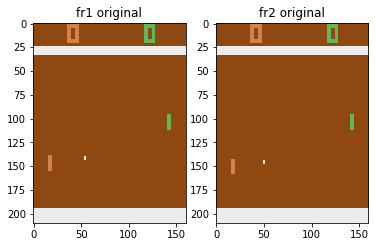

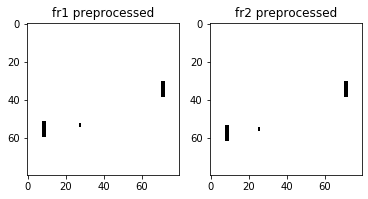

In [30]:
env.reset()
_, _, _, _ = env.step(0)
# get a frame after 20 steps
for _ in range(20):
    fr1, _, _, _ = env.step(1)
fr2, _, _, _ = env.step(0)

plt.subplot(1,2,1)
plt.imshow(fr1)
plt.title('fr1 original')
plt.subplot(1,2,2)
plt.imshow(fr2)
plt.title('fr2 original')

plt.figure()
plt.subplot(1,2,1)
plt.imshow(preprocess([fr1, fr2])[0,0].cpu(), cmap='Greys')
plt.title('fr1 preprocessed')
plt.subplot(1,2,2)
plt.imshow(preprocess([fr1, fr2])[0,1].cpu(), cmap='Greys')
plt.title('fr2 preprocessed')

print('Output of preprocess function is shaped {}.'.format(preprocess([fr1, fr2]).shape))

# 3. Define Policy Network

In [28]:
class Policy(nn.Module):

    def __init__(self):
        super(Policy, self).__init__()
        # 80x80x2 to 38x38x4
        # output = (input - kernel + 2*padding)//stride +1
            # (80 - 6 + 2*0)//2 +1 = 38
                # (38 - 6 + 2*0)//4 +1 = 9
        # 2 channel from the stacked frame
        self.conv1 = nn.Conv2d(2, 4, kernel_size=6, stride=2, bias=False)
        # 38x38x4 to 9x9x32
        self.conv2 = nn.Conv2d(4, 16, kernel_size=6, stride=4)
        self.size=9*9*16

        self.fc1 = nn.Linear(self.size, 256)
        self.fc2 = nn.Linear(256, 1)

        self.sig = nn.Sigmoid()
        
    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = F.relu(self.conv2(x))
        x = x.view(-1,self.size)
        x = F.relu(self.fc1(x))
        return self.sig(self.fc2(x))


policy=Policy().to(device)

optimizer = optim.Adam(policy.parameters(), lr=2e-4)

In [50]:
print('Passing 2 consecutive frames through "preprocess" and then passing those frames as \
input to the policy network.\n')

probabilities = policy.forward(x=preprocess([fr1, fr2]))

print('Output: {}.'.format(probabilities))

Passing 2 consecutive frames through "preprocess" and then passing those frames as input to the policy network.

Output: tensor([[0.5146]], device='cuda:0', grad_fn=<SigmoidBackward>).


# 4. Define functions
___________________

## 4.1. Collecting trajectories

In [154]:
nrand = 2
tmax = 320
bsize=4
gamma = 0.999
def rollout_trajectories(env, policy, tmax, nrand, bsize):
    states = []
    rewards = []
    probabilities = []
    actions = []
    
    for episode in range(bsize):
        env.reset()

        env.step(1)

        for _ in range(nrand):
            fr1, _, _, _ = env.step(np.random.choice([RIGHT, LEFT]))
            fr2, _, _, _ = env.step(NOOP)

        for t in range(tmax):
            x = preprocess([fr1, fr2])
            p = policy.forward(x)
            a = RIGHT if np.random.rand() < p.item() else LEFT#np.where(np.random.rand() < p.item(), RIGHT, LEFT)
            p = p if a == RIGHT else torch.tensor(1, device=device)-p#  np.where(a==RIGHT, p.item(), 1.0-p.item())

            fr1, r1, done, _ = env.step(a)
            fr2, r2, done, _ = env.step(NOOP)
            r = r1+r2

            states.append(x)
            rewards.append(r)
            probabilities.append(p)
            actions.append(a)

            if done:
                break
            
    return states, rewards, probabilities, actions

In [213]:
states, rewards, probabilities, actions = rollout_trajectories(env, policy, tmax, nrand, bsize=4)

In [262]:
def loss(policy, states, rewards, probabilities, actions, tmax, bsize, gamma):
    discount = np.tile(gamma**np.arange(tmax), bsize)
    rewards = rewards * discount
    rewards = np.reshape(np.asarray(rewards), (tmax, bsize), order='F')
    rewards_future = rewards[::-1].cumsum(axis=0)[::-1]
    rmean = np.expand_dims(np.mean(rewards_future, axis=1),1)
    rstdv = np.expand_dims(np.std(rewards_future, axis=1),1)
    rewards_norm = ((rewards_future - rmean)/(rstdv+1e-10)).reshape((tmax*bsize), order='F')
    
    probabilities = torch.stack(probabilities).squeeze().to(device)
    rewards = torch.tensor(rewards_norm, dtype=torch.float, device=device)
    
    loss = []
    for r,l in zip(rewards, probabilities):
        loss.append(r*torch.log(l))
    
    loss = torch.stack(loss).mean()
    
    return loss

In [ ]:
bsize=8
tmax=320
gamma = 0.999
nrand = 2
scores = []
batches = 500
#600 + 500 at tmax 100, +500 at tmax 320

#policy=Policy().to(device)
optimizer = optim.Adam(policy.parameters(), lr=2e-4)


widget = ['training loop: ', pb.Percentage(), ' ', 
          pb.Bar(), ' ', pb.ETA() ]
timer = pb.ProgressBar(widgets=widget, maxval=batches).start()


for batch in range(batches):
    
    states, rewards, probabilities, actions = rollout_trajectories(env, policy, tmax, nrand, bsize)
    
    total_rewards = np.sum(rewards)/bsize
    scores.append(total_rewards)
    
    L=-loss(policy, states, rewards, probabilities, actions, tmax, bsize, gamma)
    
    optimizer.zero_grad()
    L.backward()
    optimizer.step()
    
    #del L
    
    print('Batch #{}/{}, score {}.'.format(batch+1, batches, total_rewards))
    
    timer.update(batch+1)
timer.finish()
torch.save(policy, 'pongReinforce_21032020.policy')

Batch #1/500, score -8.125.


Batch #2/500, score -6.125.


Batch #3/500, score -7.75.


Batch #4/500, score -5.5.


Batch #5/500, score -5.375.


Batch #6/500, score -5.25.


Batch #7/500, score -6.125.


Batch #8/500, score -5.125.


Batch #9/500, score -4.25.


Batch #10/500, score -4.75.


Batch #11/500, score -5.75.


Batch #12/500, score -6.375.


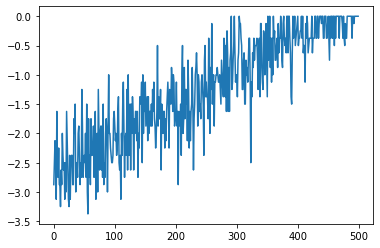

In [291]:
plt.plot(scores)

In [292]:
scores_epochs.append(scores)

ValueError: setting an array element with a sequence.

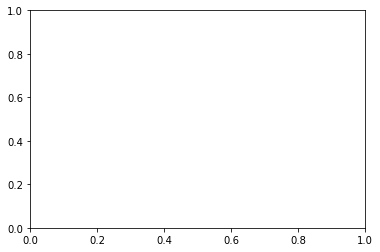

In [293]:
plt.plot(scores_epochs)

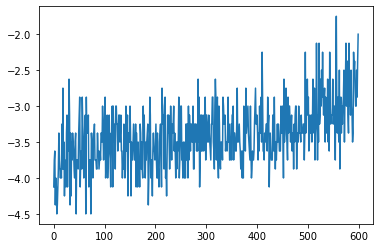

In [302]:
plt.plot(scores_epochs[0])

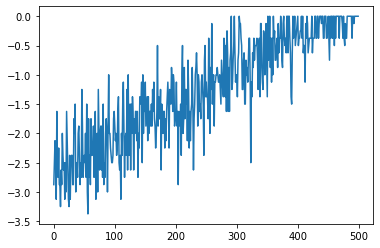

In [303]:
plt.plot(scores_epochs[1])